# TinyML - Kolmogorov-Arnold Network (KAN)

**Author:** Thommas Kevin Sales Flores  
**Institution:** Federal University of Rio Grande do Norte

## Objective
This notebook demonstrates the process of training a Kolmogorov-Arnold Network (KAN) model to predict the State of Charge (SoC) of a battery using a cleaned dataset. The project is framed within the TinyML context, highlighting the potential for efficient, novel neural network architectures on edge devices.

The workflow is structured into the following clear phases:
1.  **Environment Setup:** Import necessary libraries.
2.  **Data Acquisition:** Load the dataset.
3.  **Data Preprocessing:** Prepare the data for the model (normalization, train-test split, tensor conversion).
4.  **Model Definition & Training:** Initialize, train, and evaluate the KAN model.
5.  **Results & Evaluation:** Analyze model performance and visualize errors.
6.  **Conclusion:** Summarize findings and potential next steps.

First, we import all required libraries. This ensures all dependencies are loaded before execution.
*   `pandas`, `numpy`: Data manipulation.
*   `scikit-learn`: Data preprocessing (scaling, train-test split).
*   `torch`: Core library for tensor operations and model definition.
*   `kan`: The KAN model library.
*   `matplotlib`, `seaborn`: Data visualization and plotting.
*   `carbontracker`: (Optional) For tracking energy consumption during training.
*   `warnings`: To suppress non-critical alerts for a cleaner output.

## 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import time
import warnings
import sympy as sp

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Deep Learning & Model
import torch
from kan import KAN

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sympy import nsimplify, simplify
import sympy


# Optional: Carbon Emission Tracking
# from carbontracker.tracker import CarbonTracker

# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore")

## 2. Data Acquisition

We load the cleaned dataset from the specified path. It's crucial to verify the path is correct to avoid `FileNotFoundError`.


In [2]:
# Construct the path to the dataset dynamically relative to the notebook's location
base_path = os.getcwd().split("codes")[0]  # Adjust based on your project structure
data_path = os.path.join(base_path, "data", "dataset_clean.csv")
print(f"Loading data from: {data_path}")

# Load the data into a DataFrame
try:
    df = pd.read_csv(data_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {data_path}. Please check the path.")

# Display the first few rows to inspect the data
df.head()

Loading data from: c:\Users\thomm\OneDrive\Desktop\Repositorios\TinyML\27_KAN\data\dataset_clean.csv
Data loaded successfully. Shape: (16722, 8)


,Unnamed: 0,Battery Voltage [V],Velocity [km/h],Battery Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Throttle [%],SoC [%]
0,0,392.00,0.0,21.0,22.5,21.0,3.03,86.5
1,1,392.00,0.0,21.0,22.5,21.0,8.63,86.5
2,2,392.00,0.0,21.0,22.5,21.0,11.34,86.5
3,3,391.95,0.0,21.0,22.5,21.0,13.29,86.5
4,4,391.90,0.0,21.0,22.5,21.0,15.99,86.5


## 3. Data Preprocessing

### 3.1 Data Normalization

Neural networks typically perform better with normalized data. We scale all features to a range of [0, 1] using `MinMaxScaler`. This helps the model converge faster and perform better.

**Note:** The original code had an error: `df_scaled = pd.DataFrame(df)` simply created a copy of the original DataFrame without scaling. The corrected code uses the fitted scaler to transform the data.

In [3]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the data and transform the features
# We scale all features. If the target variable 'SoC [%]' is included, it would also be scaled.
df_scaled = scaler.fit_transform(df)

# Convert the scaled NumPy array back to a DataFrame for easier handling
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
print("Data normalized successfully.")
df_scaled.head()

Data normalized successfully.


,Unnamed: 0,Battery Voltage [V],Velocity [km/h],Battery Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Throttle [%],SoC [%]
0,0.000000,0.938692,0.0,0.0,0.0,0.969697,0.031438,1.0
1,0.000060,0.938692,0.0,0.0,0.0,0.969697,0.089541,1.0
2,0.000120,0.938692,0.0,0.0,0.0,0.969697,0.117659,1.0
3,0.000179,0.937485,0.0,0.0,0.0,0.969697,0.137892,1.0
4,0.000239,0.936278,0.0,0.0,0.0,0.969697,0.165906,1.0


### 3.2 Separation into Features and Target
We separate the dataset into:
*   **Features (X):** All columns except the target variable ('SoC [%]').
*   **Target (y):** The column we want to predict ('SoC [%]').

In [4]:
X = df_scaled.drop(columns=['SoC [%]'])  # Input features
y = df_scaled['SoC [%]']                 # Target variable

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")


Feature matrix shape: (16722, 7)
Target vector shape: (16722,)


### 3.3 Train-Test Split
We split the data into training and testing sets. This allows us to evaluate the model's performance on unseen data.
*   `test_size=0.2`: 20% of the data is reserved for testing.
*   `random_state=42`: Ensures the split is reproducible.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set - Features: {X_train.shape}, Target: {y_train.shape}")
print(f"Testing set - Features: {X_test.shape}, Target: {y_test.shape}")

Training set - Features: (13377, 7), Target: (13377,)
Testing set - Features: (3345, 7), Target: (3345,)


### 3.4 PyTorch Tensor Conversion
KAN models are built with PyTorch, which requires input data to be in the form of `torch.Tensor` objects. We convert our NumPy arrays into tensors and store them in a dictionary for easy access during training.

In [6]:
# Create a dictionary to hold our datasets
dataset = {}

# Get the default torch data type (e.g., torch.float32)
dtype = torch.get_default_dtype()

# Convert training and testing data to PyTorch tensors
# .values is used to get the underlying NumPy array from pandas DataFrames/Series
# unsqueeze(1) adds an extra dimension to y to change its shape from (n_samples,) to (n_samples, 1)
dataset['train_input'] = torch.from_numpy(X_train.values).type(dtype)
dataset['test_input'] = torch.from_numpy(X_test.values).type(dtype)
dataset['train_label'] = torch.from_numpy(y_train.values).unsqueeze(1).type(dtype) # Model expects 2D target
dataset['test_label'] = torch.from_numpy(y_test.values).unsqueeze(1).type(dtype)

print("Data successfully converted to PyTorch tensors.")

Data successfully converted to PyTorch tensors.


## 4. Model Definition and Training

### 4.1 Model Initialization
We initialize the KAN model by defining its architecture.
*   `width=[7, 5, 1]`: The network has an input layer with 7 features, one hidden layer with 5 neurons, and an output layer with 1 neuron (predicting SoC).
*   `grid=5`: The number of grid intervals used for the spline functions.
*   `k=3`: The order of the B-spline (e.g., 3 for cubic splines).
*   `seed=0`: Sets the random seed for reproducibility.

In [7]:
# Define the model architecture
model = KAN(width=[X_train.shape[1], 5, 1], grid=5, k=3, seed=0)

checkpoint directory created: ./model
saving model version 0.0


### 4.2 Model Training
We train the model using the prepared dataset.
*   `opt="Adam"`: The Adam optimizer is used for gradient descent.
*   `lr=1e-3`: The learning rate for the optimizer.
*   `steps=2000`: The number of training iterations (epochs).
*   `update_grid=True`: Allows the grid points for splines to be updated during training.


**Note:** The `Carbontracker` code is commented out but can be uncommented to measure the energy cost of training, which is highly relevant for TinyML.

In [8]:
# Optional: Initialize carbon tracker
# tracker_KAN = CarbonTracker(epochs=1)
# tracker_KAN.epoch_start()

start_time = time.time()

# Train the model
results = model.fit(
    dataset,
    opt="Adam",
    lr=1e-3,
    steps=1000,
    update_grid=True
)

end_time = time.time()
execution_time = end_time - start_time

# tracker_KAN.epoch_end()
# tracker_KAN.stop()

print(f"Training completed. Execution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")


| train_loss: 9.00e-03 | test_loss: 9.22e-03 | reg: 1.45e+01 | : 100%|█| 1000/1000 [03:23<00:00,  4.

saving model version 0.1
Training completed. Execution time: 203.04 seconds (3.38 minutes)


### 4.3 Plotting Training and Test Loss
-  This plot is essential for diagnosing the model's learning process.
-  It helps identify if the model is learning properly, overfitting, or underfitting.

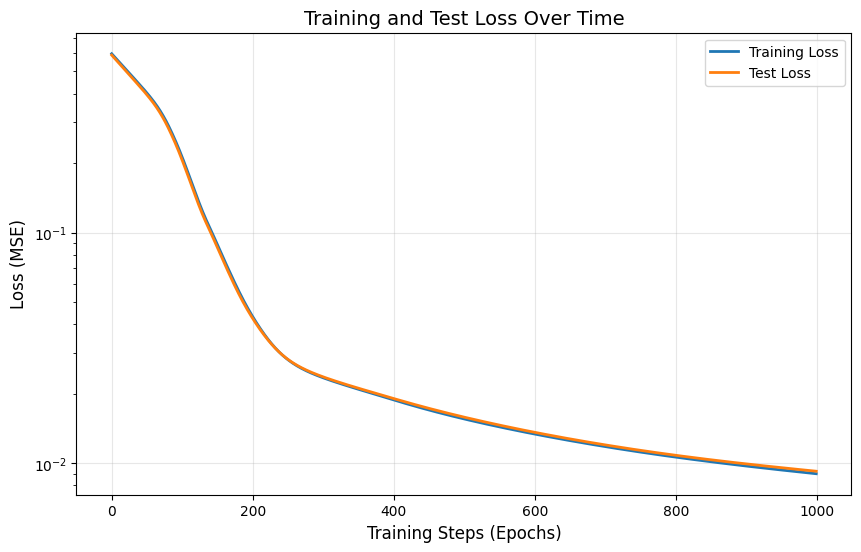

Final Training Loss: 8.9969e-03
Final Test Loss:     9.2230e-03


In [21]:
# Extract the loss history from the results
# The 'results' dict typically has keys like 'train_loss', 'test_loss', 'reg'
train_loss = results.get('train_loss', [])
test_loss = results.get('test_loss', [])
# Note: 'reg' is the regularization loss, which might be interesting to plot separately.

# Create the plot
plt.figure(figsize=(10, 6))

# Plot training and test loss
plt.plot(train_loss, label='Training Loss', linewidth=2)
plt.plot(test_loss, label='Test Loss', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Training Steps (Epochs)', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss Over Time', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Use logarithmic scale if the loss values span several orders of magnitude
# This can make it easier to see the details of the convergence.
plt.yscale('log')

# Save the figure
plt.savefig('./figures/training_test_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final loss values for a quick summary
print(f"Final Training Loss: {train_loss[-1]:.4e}")
print(f"Final Test Loss:     {test_loss[-1]:.4e}")

### 4.4 Model Architecture Plot
One of the key advantages of KANs is their interpretability. We can visualize the learned activation functions for each node and connection in the network. This provides insight into what mathematical transformations the model is applying to the input features.

<Figure size 1200x1000 with 0 Axes>

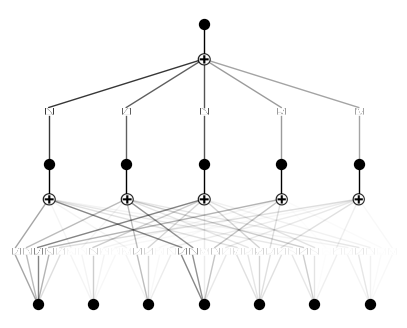

In [9]:
# Plot the trained KAN architecture
# The plot shows the spline function for each connection, giving a visual intuition of the model's learned mappings.
plt.figure(figsize=(12, 10))
model.plot()
plt.savefig('./figures/kan_architecture.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.5 Symbolic Regression (Extracting Interpretable Formulas)
KANs can automatically discover symbolic formulas that approximate the learned spline functions. This is a powerful step towards a truly interpretable model, as it can provide a human-readable mathematical equation for the relationship between inputs and output.

In [10]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin')
    model.fix_symbolic(0,1,0,'x^2')
    model.fix_symbolic(1,0,0,'exp')
elif mode == "auto":
    # automatic mode
    # lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    lib = ['x','x^2','x^3','x^4']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.8864080905914307, c=1
fixing (0,0,1) with x, r2=0.888986349105835, c=1
fixing (0,0,2) with x, r2=0.8978589773178101, c=1
fixing (0,0,3) with x, r2=0.9328470826148987, c=1
fixing (0,0,4) with x, r2=0.7663233876228333, c=1
fixing (0,1,0) with x, r2=0.7280860543251038, c=1
fixing (0,1,1) with x, r2=0.9647716879844666, c=1
fixing (0,1,2) with x, r2=0.9874396920204163, c=1
fixing (0,1,3) with x, r2=0.6268463730812073, c=1
fixing (0,1,4) with x, r2=0.5536190271377563, c=1
fixing (0,2,0) with x, r2=0.002868778770789504, c=1
fixing (0,2,1) with x^2, r2=0.9990513324737549, c=2
fixing (0,2,2) with x, r2=0.9709054827690125, c=1
fixing (0,2,3) with x, r2=0.2999360263347626, c=1
fixing (0,2,4) with x, r2=0.9833963513374329, c=1
fixing (0,3,0) with x, r2=0.9826601147651672, c=1
fixing (0,3,1) with x, r2=0.9956023097038269, c=1
fixing (0,3,2) with x, r2=0.21505677700042725, c=1
fixing (0,3,3) with x, r2=0.9027935862541199, c=1
fixing (0,3,4) with x, r2=0.9759414196014404, 

In [11]:
def ex_round(ex1, n_digit):
    '''
    rounding the numbers in an expression to certain floating points
    
    Args:
    -----
        ex1 : sympy expression
        n_digit : int
        
    Returns:
    --------
        ex2 : sympy expression
    
    Example
    -------
    >>> from kan.utils import *
    >>> from sympy import *
    >>> input_vars = a, b = symbols('a b')
    >>> expression = 3.14534242 * exp(sin(pi*a) + b**2) - 2.32345402
    >>> ex_round(expression, 2)
    '''
    ex2 = ex1
    for a in sympy.preorder_traversal(ex1):
        if isinstance(a, sympy.Float):
            ex2 = ex2.subs(a, round(a, n_digit))
    return ex2

In [12]:
formula_simplify = model.symbolic_formula()[0][0]
nsimplify(ex_round(formula_simplify, 5))

-27713*x_1/50000 + 11067*x_2/100000 - 901*x_3/20000 - 33003*x_4/100000 - 9317*x_5/100000 + 22849*x_6/100000 + 1839*x_7/50000 - 1543*(21527/100000 - x_7)**2/20000 + 1099*(-x_3 - 9317/100000)**2/12500 + 539*(-x_7 - 4529/25000)**2/10000 + 5301/6250

<Figure size 1200x1000 with 0 Axes>

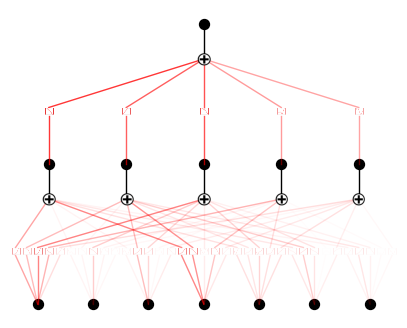

In [13]:
# Plot the trained KAN architecture simplify
# The plot shows the spline function for each connection, giving a visual intuition of the model's learned mappings.
plt.figure(figsize=(12, 10))
model.plot()
plt.savefig('./figures/kan_architecture_simplify.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Results and Evaluation

### 5.1 Error Analysis
We calculate the prediction error on the test set and analyze its distribution. A well-trained model should have errors centered around zero with a small variance.

In [14]:
# Calculate the prediction error on the test set
with torch.no_grad(): # Disable gradient calculation for inference
    predictions = model(dataset['test_input'])
    error = (dataset['test_label'] - predictions).numpy()

# Calculate error statistics
error_mean = np.mean(error)
error_std = np.std(error)
error_max = np.max(np.abs(error)) # Using absolute value for max magnitude
error_min = np.min(np.abs(error)) # Using absolute value for min magnitude

print("Error Analysis on Test Set:")
print(f"  Mean Error: {error_mean:.4f}")
print(f"  Standard Deviation: {error_std:.4f}")
print(f"  Max Absolute Error: {error_max:.4f}")
print(f"  Min Absolute Error: {error_min:.4f}")

Error Analysis on Test Set:
  Mean Error: 0.0003
  Standard Deviation: 0.0688
  Max Absolute Error: 0.2023
  Min Absolute Error: 0.0000


### 5.2 Error Distribution Plot
We visualize the distribution of errors to better understand the model's performance. A symmetric, bell-shaped distribution centered at zero is ideal.

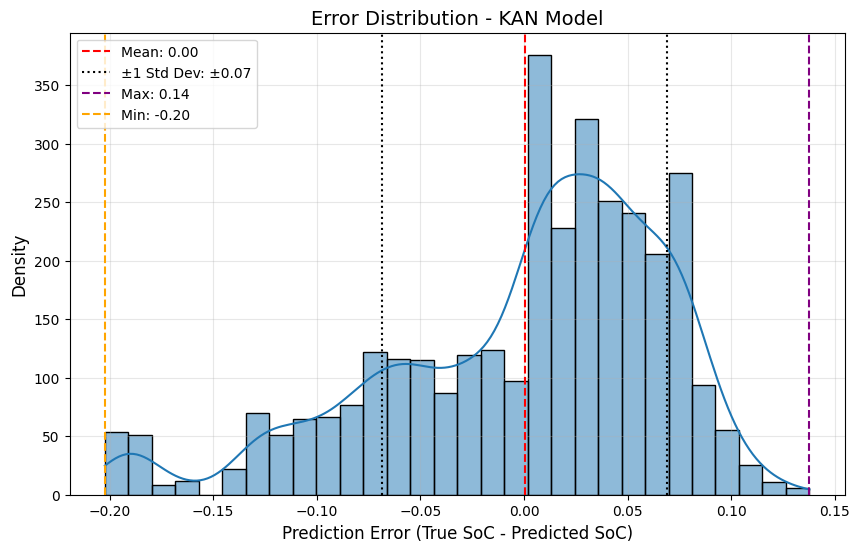

In [15]:
# Define a function for reusable plotting
def plot_error(error, model_name, save_path=None):
    """
    Plots a histogram of the prediction errors with key statistics.

    Parameters:
        error (np.ndarray): Array of prediction errors.
        model_name (str): Name of the model for the plot title.
        save_path (str, optional): Path to save the figure.
    """
    # Calculate statistics
    error_mean = np.mean(error)
    error_std = np.std(error)
    error_max = np.max(error)
    error_min = np.min(error)

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(error, bins=30, kde=True, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f'Error Distribution - {model_name}', fontsize=14)
    ax.set_xlabel('Prediction Error (True SoC - Predicted SoC)', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.grid(True, alpha=0.3)

    # Add vertical lines for statistics
    ax.axvline(error_mean, color='red', linestyle='--', label=f'Mean: {error_mean:.2f}')
    ax.axvline(error_mean - error_std, color='black', linestyle=':', label=f'±1 Std Dev: ±{error_std:.2f}')
    ax.axvline(error_mean + error_std, color='black', linestyle=':')
    ax.axvline(error_max, color='purple', linestyle='--', label=f'Max: {error_max:.2f}')
    ax.axvline(error_min, color='orange', linestyle='--', label=f'Min: {error_min:.2f}')

    ax.legend()

    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot the error distribution for the KAN model
plot_error(error, 'KAN Model', save_path='./figures/error_distribution_KAN.png')

### 5.3 Visualizing Predictions vs. Actuals
A scatter plot of True vs. Predicted values is another excellent way to assess model performance. A perfect model would have all points on the line y=x.

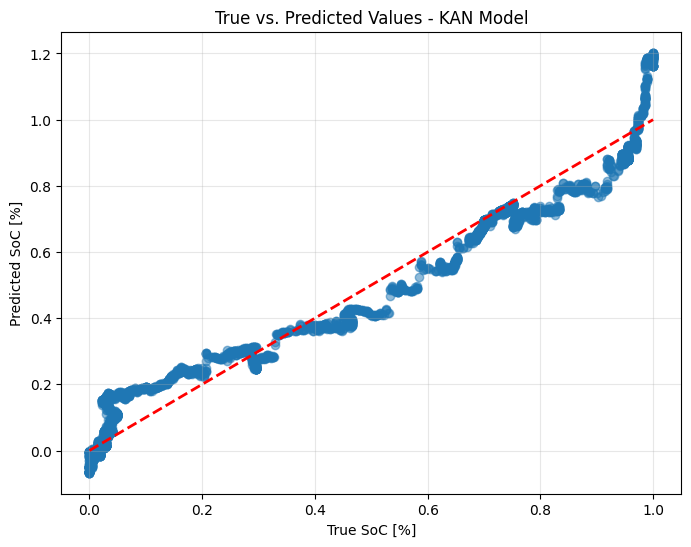

In [16]:
# Create predictions vs. actuals plot
with torch.no_grad():
    y_pred = model(dataset['test_input']).numpy()
    y_true = dataset['test_label'].numpy()

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2) # Perfect prediction line
plt.xlabel('True SoC [%]')
plt.ylabel('Predicted SoC [%]')
plt.title('True vs. Predicted Values - KAN Model')
plt.grid(True, alpha=0.3)
plt.savefig('./figures/true_vs_predicted_KAN.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Deployment: Transforming to C++ Code

A significant advantage of KANs in the TinyML context is their potential for efficient and interpretable deployment. The symbolic formula we extracted is not just for show; it can be directly translated into a very lightweight, dependency-free C++ function. This is ideal for microcontrollers with limited resources.

**Note:** The exact output of `to_cpp` will depend on the complexity of the discovered symbolic formula.

In [17]:
experiment = 0

def transform_expression(equation):
    # Replace ** with ^ for easier parsing with sympy
    modified_eq = equation.replace('**', '^')

    # Parse the equation to a sympy expression
    expr = sp.sympify(modified_eq)

    # Recursive function to replace exponents with pow
    def replace_pow(expr):
        if expr.is_Pow:
            base, exponent = expr.args
            return sp.Function('pow')(replace_pow(base), replace_pow(exponent))
        elif expr.is_Function:
            return expr.func(*[replace_pow(arg) for arg in expr.args])
        elif expr.is_Add or expr.is_Mul:
            return expr.func(*[replace_pow(arg) for arg in expr.args])
        else:
            return expr

    transformed_expr = replace_pow(expr)

    return str(transformed_expr)

def generate_arduino_function(formula_string, input_size):
    # Transform the formula
    formula_string = transform_expression(formula_string)

    # Replace Python-style functions with C++ equivalents
    formula_string = formula_string.replace('sin', 'std::sin')
    formula_string = formula_string.replace('cosh', 'cosh')
    formula_string = formula_string.replace('cos', 'std::cos')
    formula_string = formula_string.replace('tan', 'std::tan')
    formula_string = formula_string.replace('sqrt', 'std::sqrt')
    formula_string = formula_string.replace('exp', 'std::exp')
    formula_string = formula_string.replace('log', 'std::log')
    formula_string = formula_string.replace('tanh', 'std::tanh')
    formula_string = formula_string.replace('abs', 'std::abs')
    formula_string = formula_string.replace('pow', 'std::pow')
    formula_string = formula_string.replace('sigmoid', '1 / (1 + std::exp(-x))')
    formula_string = formula_string.replace('relu', '(x > 0) ? x : 0')
    formula_string = formula_string.replace('sgn', '(x > 0) - (x < 0)')
    formula_string = formula_string.replace('arcsin', 'std::asin')
    formula_string = formula_string.replace('arctan', 'std::atan')
    formula_string = formula_string.replace('arctanh', 'std::atanh')
    formula_string = formula_string.replace('gaussian', 'std::exp(-x * x)')

    # Generate the content of the .h header file
    header_content = """
    #ifndef KAN_MODEL_H
    #define KAN_MODEL_H

    #include <cmath>

    """

    # Define the function prototype and body
    header_content += 'float predict('
    for input in range(1, input_size + 1):
        if input == input_size:
            header_content += f'float x_{input})'
        else:
            header_content += f'float x_{input}, '

    header_content += f"""
    {{
        float result = ({formula_string});
        return result;
    }}

    #endif // KAN_MODEL_H
    """
    return header_content

In [24]:
formula = model.symbolic_formula()
formula_transform = f'{formula[0]}'.split('[')[1].split(']')[0]
formula_transform

'-0.55425982936965*x_1 + 0.110666238518483*x_2 - 0.0450471091341996*x_3 - 0.330026542054321*x_4 - 0.0931681484426096*x_5 + 0.228486458628294*x_6 + 0.0367771005214196*x_7 - 0.0771479301391296*(0.215272135206579 - x_7)**2 + 0.0879234933576154*(-x_3 - 0.0931694283586403)**2 + 0.0538988046415818*(-x_7 - 0.181158237036153)**2 + 0.848163410733748'

In [19]:
cpp_code = generate_arduino_function(formula_transform, X_train.shape[1])
print(cpp_code)


    #ifndef KAN_MODEL_H
    #define KAN_MODEL_H

    #include <cmath>

    float predict(float x_1, float x_2, float x_3, float x_4, float x_5, float x_6, float x_7)
    {
        float result = (-0.55425982936965*x_1 + 0.110666238518483*x_2 - 0.0450471091341996*x_3 - 0.330026542054321*x_4 - 0.0931681484426096*x_5 + 0.228486458628294*x_6 + 0.0367771005214196*x_7 - 0.0771479301391296*std::pow(0.215272135206579 - x_7, 2) + 0.0879234933576154*std::pow(-x_3 - 0.0931694283586403, 2) + 0.0538988046415818*std::pow(-x_7 - 0.181158237036153, 2) + 0.848163410733748);
        return result;
    }

    #endif // KAN_MODEL_H
    


In [22]:
with open('./ArduinoCode/kan_model.h', 'w') as f:
    f.write(cpp_code)
print("\nC++ code saved to './ArduinoCode/kan_model.h'")


C++ code saved to './ArduinoCode/kan_model.h'
